In [5]:
from warnings import filterwarnings

filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.signal import lfilter

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from modules.data_fetcher import download_historical_data

# Hurst Exponent

- H < 0.5 — a mean-reverting (anti-persistent) series. The closer the value is to 0, the stronger the mean-reversion process is. In practice, it means that a high value is followed by a low value and vice-versa.
- H = 0.5 — a geometric random walk.
- H > 0.5 — a trending (persistent) series. The closer the value is to 1, the stronger the trend. In practice, it means that a high value is followed by a higher on

In [2]:
SYMBOL= 'BTC-USDT'

df = download_historical_data(SYMBOL,'1hour').iloc[-3000:]
df["Return"] = df.Close.pct_change()
df.dropna(inplace=True)
print(df.shape)
df.head()

(2999, 8)


,Timestamp,Open,Close,High,Low,Amount,Volume,Return
Date,,,,,,,,
2022-10-25 10:00:00,1.666685e+09,19306.7,19295.5,19323.5,19269.6,281.055517,5.425897e+06,-0.000554
2022-10-25 11:00:00,1.666688e+09,19295.4,19266.3,19296.1,19257.0,291.026014,5.610201e+06,-0.001513
2022-10-25 12:00:00,1.666692e+09,19266.3,19296.2,19298.9,19237.5,259.489626,5.001039e+06,0.001552
2022-10-25 13:00:00,1.666696e+09,19296.4,19301.3,19328.9,19275.6,205.836094,3.972412e+06,0.000264
2022-10-25 14:00:00,1.666699e+09,19301.3,19325.5,19343.7,19260.0,297.347957,5.737919e+06,0.001254


In [6]:
power=4
n=2**power

def get_hurst_exponent(time_series:pd.Series)->float:
    """Returns the Hurst Exponent of the time series"""
    
    time_series = time_series.values
    max_lag=20#len(time_series//2)
    
    lags = range(2, max_lag)
    
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

def get_hurst_exponent_dsod(time_series:pd.Series)->float:
    y = np.cumsum(np.diff(time_series, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)

 #min_chunksize=8, max_chunksize=200, num_chunksize=5
 
def get_hurst_exponent_dma(time_series:pd.Series)->float:
    max_chunksize = 200
    num_chunksize = 5
    min_chunksize = 8
    
    prices = time_series.values
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    
    return H

def get_hurst_exponent_rs(time_series:pd.Series)->float:
    x = time_series.values
    N = len(x)
    max_chunksize = 200
    num_chunksize = 5
    min_chunksize = 8
    
    
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    #out[0] = H
    return H


from statsmodels.regression.linear_model import OLS
from statsmodels.api import add_constant

def calculate_rs(rows_array:pd.Series)->float:
    data = rows_array.values
    X = np.arange(2,power+1)
    Y = np.array([])
    for p in X:
        m=2**p
        s=2**(power-p)
        rs_array = np.array([])
        for i in np.arange(0,s):
            subsample=data[i*m:(i+1)*m]
            deviate = np.cumsum(subsample-np.average(subsample))
            diff= max(deviate)-min(deviate)
            stdev = np.std(subsample)
            rs_array  = np.append(rs_array,diff/stdev)
        Y = np.append(Y,np.log2(np.average(rs_array)))
    reg = OLS(Y,add_constant(X))
    res = reg.fit()
    return res.params[1]
   


In [7]:
df['Hurst_expo'] = df['Close'].rolling(n).apply(get_hurst_exponent)
df['Hurst_expo_dsod'] = df['Close'].rolling(n).apply(get_hurst_exponent_dsod)
#df['Hurst_expo_dma'] = df['Close'].rolling(100).apply(get_hurst_exponent_dma)
df['Hurst_expo_rs'] = df['Close'].rolling(n).apply(get_hurst_exponent_rs)
df['Hurst_expo_rs_2'] = df['Close'].rolling(n).apply(calculate_rs)

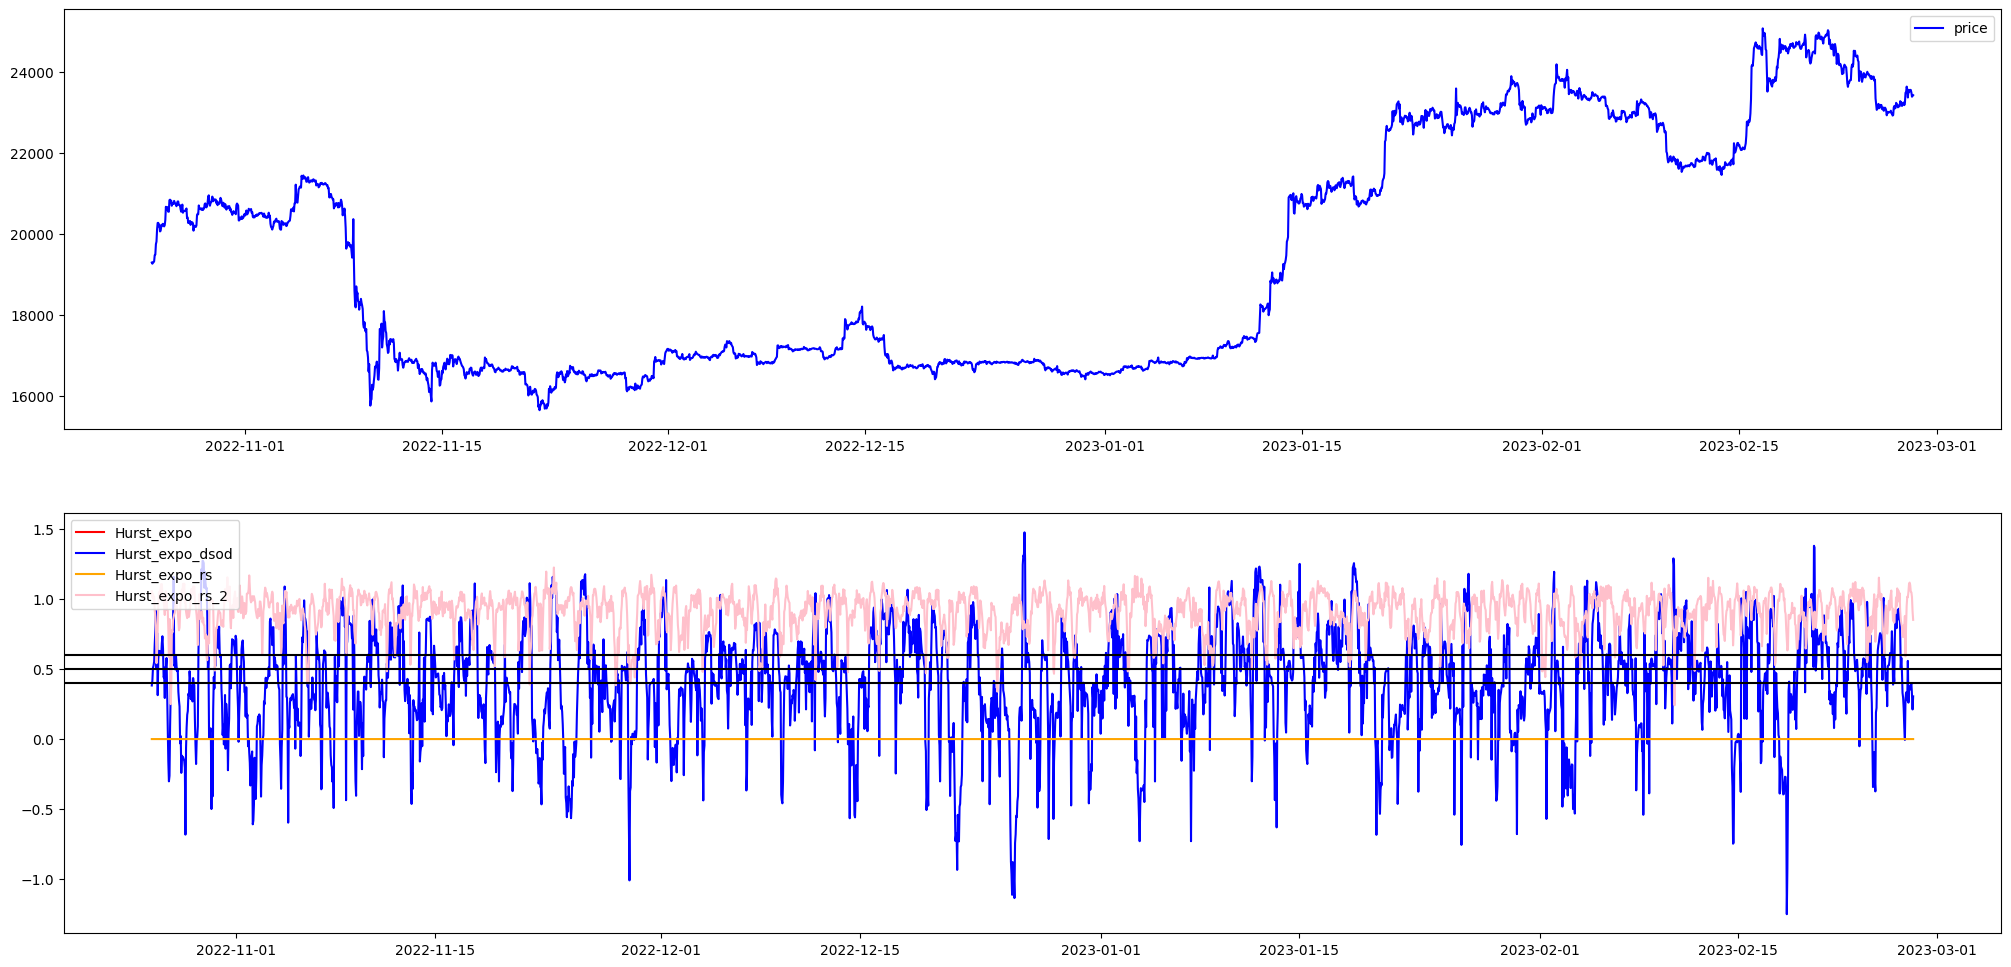

In [8]:
fig, ax = plt.subplots(2,1,figsize=(25,12))
ax[0].plot(df.Close,color='blue',label="price")
ax[0].legend()

ax[1].plot(df.Hurst_expo,color='r',label="Hurst_expo")
ax[1].plot(df.Hurst_expo_dsod,color='b',label="Hurst_expo_dsod")
# ax[1].plot(df.Hurst_expo_dma,color='r',label="Hurst_expo_dma")
ax[1].plot(df.Hurst_expo_rs,color='orange',label="Hurst_expo_rs")
ax[1].plot(df.Hurst_expo_rs_2,color='pink',label="Hurst_expo_rs_2")
ax[1].axhline(y=0.5, color='black')
ax[1].axhline(y=0.6, color='black')
ax[1].axhline(y=0.4, color='black')
ax[1].legend(loc='upper left')

# Multifractal Detrended Fluctuation Analysis

In [ ]:
from MFDFA import MFDFA
from MFDFA import fgn
# where this second library is to generate fractional Gaussian noises

# integration time and time sampling
t_final = 2000
delta_t = 0.001

# Some drift theta and diffusion sigma parameters
theta = 0.3
sigma = 0.1

# The time array of the trajectory
time = np.arange(0, t_final, delta_t)

# The fractional Gaussian noise
H = 0.7
dB = (t_final ** H) * fgn(N = time.size, H = H)

# Initialise the array y
y = np.zeros([time.size])

# Integrate the process
for i in range(1, time.size):
    y[i] = y[i-1] - theta * y[i-1] * delta_t + sigma * dB[i]

In [ ]:
# Select a band of lags, which usually ranges from
# very small segments of data, to very long ones, as
lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
# Notice these must be ints, since these will segment
# the data into chucks of lag size

# Select the power q
q = 2

# The order of the polynomial fitting
order = 1

# Obtain the (MF)DFA as
lag, dfa = MFDFA(y, lag = lag, q = q, order = order)

In [ ]:
# To uncover the Hurst index, lets get some log-log plots
plt.loglog(lag, dfa, 'o', label='fOU: MFDFA q=2')

# And now we need to fit the line to find the slope. Don't
# forget that since you are plotting in a double logarithmic
# scales, you need to fit the logs of the results
H_hat = np.polyfit(np.log(lag)[4:20],np.log(dfa[4:20]),1)[0]

# Now what you should obtain is: slope = H + 1
print('Estimated H = '+'{:.3f}'.format(H_hat[0]))